This is the notebook recreating our experiments for the submission "Decision-making under miscalibration".

# Imports

In [ ]:
# may require restarting the runtime,
# required to load the data for the experiment.
!pip install pyreadstat

In [10]:
from contextlib import suppress
import numpy as np
from matplotlib import pyplot as plt
from sklearn.calibration import calibration_curve
from google.colab import files
%matplotlib inline
import seaborn as sns
from sklearn.metrics import RocCurveDisplay

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

import tensorflow as tf
np.set_printoptions(precision=2, suppress=True)

# Definitions of the conservative therapeutic threhsolds

In [2]:
def optimal_threshold_mce(j_star, m, alpha):
  # this is the derivation for constant predictors.
  if alpha == 0:
    return j_star
  elif 1 <= j_star <= alpha*m/2:
    return 1
  elif alpha*m/2 < j_star <= alpha*m:
    return 2*j_star - alpha*m
  elif alpha*m < j_star <= (1-alpha)*m:
    return j_star
  elif (1-alpha)*m < j_star <= (1-alpha/2)*m:
    return 2*j_star - (1-alpha)*m
  elif (1-alpha/2)*m < j_star <= m:
    return m
  return None

In [3]:
def optimal_threshold_ece(j_star, m, alpha):
  # this is the derivation for almost constant predicotrs.
  if alpha == 0:
    return j_star
  elif 1 <= j_star <= alpha*m:
    # Gal: changed
    return max(1,(1+alpha)*m - (alpha*(m**2))/j_star)
  elif alpha*m < j_star <= (1-alpha)*m:
    return j_star
  elif (1-alpha)*m < j_star <= m:
    return min(m, alpha*m*j_star/(m-j_star))
  return None


In [4]:
def optimal_threshold(j_star, m, alpha, method):
  assert method in ['ece', 'mce']

  if method == 'mce':
    return optimal_threshold_mce(j_star, m, alpha)
  elif method == 'ece':
    return optimal_threshold_ece(j_star, m, alpha)

# Synthetic data generation

In [125]:
def normalize(preds):
    preds  = preds - preds.min()
    preds = preds / preds.max()
    return preds 

def draw_labels(p):
  return np.random.binomial(n=1, p=p)

def inject_noise(p, scale=1e-2):
  delta = np.random.randn(p.shape[0]) * scale
  return np.clip(p + delta, 0, 1)

def draw_random_p_star(n, mode='normal', mixture_centers=[0.1, 0.5, 0.9], mixture_weights=[0.45, 0.1, 0.45]):
  if mode == 'normal':
    preds = np.random.randn(n, )
    preds = normalize(preds)
  if mode == 'uniform':
    preds = np.random.uniform(0, 1, n)
  if mode == 'mixtures':
    preds = []
    for mixture_center, mixture_weight in zip(mixture_centers, mixture_weights):
      p = np.random.randn(int(n*mixture_weight))/10 + mixture_center
      preds.extend(p)
    # normalize
    preds = np.array(preds)
    preds = normalize(preds)
  return preds  

# Net Benefit computation

In [6]:
def compute_tp(y, y_hat):
  return len(np.where(np.logical_and(y==1,y_hat==1))[0])

def compute_fp(y, y_hat):
  return len(np.where(np.logical_and(y==0,y_hat==1))[0])

In [7]:
def net_benefit(preds,  y, j, j_star, m):
  if j_star <= m/2:
    l_prime = 1
    p_prime = (m - j_star)/j_star
  else:
    p_prime = 1
    l_prime = j_star / (m - j_star)

  y_hat = preds > j/m


  n = preds.shape[0]

  tp = compute_tp(y, y_hat)
  fp = compute_fp(y, y_hat)

  return (p_prime * tp - l_prime * fp)/n

def compute_net_benefits(preds, y, j, j_star, m):
  nb_p = net_benefit(preds=preds, y=y, j=j, j_star=j_star, m=m)
  nb_all = net_benefit(preds=preds, y=y, j=1, j_star=j_star, m=m)
  nb_none = net_benefit(preds=preds, y=y, j=m, j_star=j_star, m=m)
  return nb_p, nb_all, nb_none

def clinical_utility(preds,  y, j, j_star, m):
  nb_p, nb_all, nb_none = compute_net_benefits(preds, y, j, j_star, m)
  return nb_p - max(nb_all, nb_none)

In [131]:
def compute_and_plot_decision_curves(preds, y, m, mode, alpha=0, method='ece', ax=None, bound=None, plot=True):
  """
  Plotting the decision curves for the given data.
  If alpha is 0, use the therapeutic threshold j_star.
  Otherwise, use the conservative threshold for the method given by method.
  """
  assert mode in ['net-benefits', 'clinical-utility', 'all']
  if plot:
    if ax is None:
      ax = plt
      if bound is not None:
        ax.ylim(bound)
      else:
        ax.ylim([-1, 1])
    else:
      if bound is not None:
        ax.set_ylim(bound)
      else:
        ax.set_ylim([-1, 1])
  j_stars = np.arange(1, m, step=1)
  nb_p_list = []
  nb_all_list = []
  nb_none_list = []
  cu_list = []

  for j_star in j_stars:
    j = optimal_threshold(j_star, m, alpha, method)
    nb_p, nb_all, nb_none = compute_net_benefits(preds, y, j, j_star, m)
    cu = nb_p - max(nb_all, nb_none)
    cu_list.append(cu)
    nb_p_list.append(nb_p)
    nb_all_list.append(nb_all)
    nb_none_list.append(nb_none)

  if plot:
    if mode in ['net-benefits', 'all']:
      ax.plot(j_stars/m, nb_p_list, label="net benefit (p)", color='black', linewidth=3)
      ax.plot(j_stars/m, nb_all_list, label="net benefit (ALL)", color='gray', linestyle='dashed', linewidth=3)
      ax.plot(j_stars/m, nb_none_list, label="net benefit (NONE)", color='gray', linestyle='dotted', linewidth=3)
    if mode in ['clinical-utility', 'all']:
      ax.plot(j_stars/m, cu_list, label="clinical utility", color='blue', linewidth=3)
    ax.legend()
  return cu_list

n = 1000 # size of the population
p_star = draw_random_p_star(n=n, mode='mixtures')
y = draw_labels(p_star)
_ = compute_and_plot_decision_curves(p_star, y, m=100, alpha=0.0, mode='all', plot=False, ax=None)

# Calibration computation

In [135]:
def plot_calibration_curves(probs, y, n_bins=10, ax=None, adaptive_bins=False, plot=True):
  """
  Compute the expected/maximum calibration error and plot a reliability (calibration) diagram.
  """

  # add calibration curve and x==y baseline
  if adaptive_bins:
    prob_true, prob_pred = calibration_curve(y, probs, n_bins=n_bins, strategy='quantile')
    gaps = np.abs(prob_pred - prob_true)
    alpha = np.mean(gaps)
  else:
    prob_true, prob_pred = calibration_curve(y, probs, n_bins=n_bins, strategy='uniform')
    gaps = np.abs(prob_pred - prob_true)
    alpha = np.max(gaps)

  #print(alpha)
  

  
  if plot:
    # plot histogram, making each bar sufficiently small
    x, bins, p=ax.hist(probs, color='lightskyblue') 
    for item in p:
        item.set_height(item.get_height()/(sum(x)))

    ax.set_ylim([-0.05,1.05])

    ax.plot(prob_pred, prob_true, '.r-', color='orange', markersize=15, linewidth=3) 
    #ax.plot(prob_true, prob_true, '--', color='gray', alpha=0.5, linewidth=3)
    ax.plot(np.arange(-0.0, 1.0, 0.01), np.arange(-0.0, 1.0, 0.01), '--', color='gray', alpha=0.5, linewidth=3)
    
    ax.set_xlim([-0.05,1.05])

    ax.set_xlabel("predicted probabilities")
    ax.set_ylabel("fraction of positives")
    if adaptive_bins:
      # alpha is the ECE
      ax.set_title(f"ECE = {alpha:.2f}", fontsize=16)
    else:
      ax.set_title(f"MCE = {alpha:.2f}", fontsize=16)

  return alpha

n = 1000 # size of the population
p_star = draw_random_p_star(n=n, mode='mixtures')
y = draw_labels(p_star)
_ = plot_calibration_curves(p_star, y, plot=False, ax=None)

# Loading the experiment dataset

The data is taken from [here](http://clinicalpredictionmodels.org/doku.php?id=rcode_and_data:start). It's in sav format.

In [11]:
def load_data(filename):
  return pd.read_spss(filename)

def preprocess_data(df, split_by=None, age_categories=5):
 
  # make age categorical
  df["age"] = pd.cut(df["age"], age_categories)

  if split_by is not None:
    options = df[split_by].unique()
    df1 = df[df[split_by] == options[0]]
    df2 = df[df[split_by] == options[1]]
    del df1[split_by]
    del df2[split_by]
    dfs = (df1, df2)
  else:
    dfs = (df)


  return dfs


def convert_to_numpy(df, numeric_features, binary_fetures, cat_features, target, test_size=0.2, random_state=3):
  features_to_keep = numeric_features + binary_fetures + cat_features + target
  df_filtered = df[features_to_keep]
  df_with_dummies = pd.get_dummies(df_filtered, columns=cat_features, drop_first=False)
  df_with_dummies = pd.get_dummies(df_with_dummies, columns=binary_fetures, drop_first=True)
  df_no_nans = df_with_dummies.dropna()
  # convert to numpy
  Y = df_no_nans[target].values
  Y = np.reshape(Y, (Y.shape[0],))
  del df_no_nans[target[0]]

  X = df_no_nans.values
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
  return X_train, X_test, y_train, y_test, list(df_no_nans)

# Additional code for plots

In [158]:
def plot_optimal_threshold(m, alpha, methods_to_plot, download=True):
  j_stars = np.arange(1, m, step=1)
  js_mce = []
  js_ece = []

  for j_star in j_stars:
    if 'mce' in methods_to_plot:
      js_mce.append(optimal_threshold(j_star, m, alpha, 'mce')) 
    if 'ece' in methods_to_plot:
      js_ece.append(optimal_threshold(j_star, m, alpha, 'ece')) 
  
  threshold_for_p_star = [j_star/m for j_star in j_stars]

  if 'mce' in methods_to_plot:
    threshold_for_p_mce = [j/m for j in js_mce]
    plt.plot(threshold_for_p_star, threshold_for_p_mce, linewidth=3, label='conservative therepeutic (MCE)', color='purple')
  if 'ece' in methods_to_plot:
    threshold_for_p_ece = [j/m for j in js_ece]
    plt.plot(threshold_for_p_star, threshold_for_p_ece, linewidth=3, label='conservative therepeutic (ECE)', color='blue')


  #for a, b in zip(threshold_for_p_star, threshold_for_p):
  #  print(a,b)

  plt.plot(threshold_for_p_star, threshold_for_p_star, linewidth=3, linestyle='dashed', label='therepeutic threshold', color='gray', alpha=0.5)

  plt.legend()

  plt.xlabel("$j^\star$",  fontsize=20)
  plt.ylabel("$\hat{j}$",  fontsize=20)
  plt.title(r"$\alpha=$" + str(alpha), fontsize=20)
  plt.tight_layout()
  plt.savefig('j_hat_illustration.png', dpi=400)
  if download:
    files.download('j_hat_illustration.png')

  return 'j_hat_illustration.png'

In [147]:
def plot_baseline_model(m, n_bins, download=False):

  random_state = np.random.randint(0, 5000)

  # define features to be used
  target = ['d.mort']
  numeric_features = ['age', 'd.sysbpt', 'glucose', 'glucoset', 'ph', 'sodium', 'sodiumt', 'hb', 'hbt']
  binary_features = ['hypoxia', 'hypotens', 'tsah', 'edh',  'shift']
  cat_features = ['cause', 'age', 'd.motor', 'd.pupil', 'pupil.i',  'ctclass',   'cisterns']
  split_by = None
  binary_features = [b for b in binary_features if b != split_by]

  # load data
  df = load_data('TBI.sav')
  df = preprocess_data(df)
  X_train, X_test, y_train, y_test, col_names = convert_to_numpy(df, numeric_features, binary_features, cat_features, target, test_size=0.5, random_state=random_state)
  pipe = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(random_state=random_state))
  pipe.fit(X_train, y_train)

  p_test = pipe.predict_proba(X_test)[:, 1]
  y_pred = pipe.decision_function(X_test)

  fig, axs = plt.subplots(1,3, figsize=(10, 4))


  alpha_ece = plot_calibration_curves(p_test, y_test, ax=axs[0], adaptive_bins=True, n_bins=n_bins) 
  #alpha_mce = plot_calibration_curves(p_test, y_test, ax=axs[1], adaptive_bins=False, n_bins=n_bins) 


  cu = compute_and_plot_decision_curves(p_test, y_test, m=m, mode='all', alpha=0.0, ax=axs[1])
  axs[1].set_title(f"alpha = 0; $E_j[CU]$ = {np.mean(cu):.4f}")
  RocCurveDisplay.from_predictions(y_test, y_pred, ax=axs[2])

  plt.tight_layout()
  plt.savefig('baseline_model.png', dpi=400)
  if download:
    files.download('baseline_model.png')

  return 'baseline_model.png'


In [148]:
def compare_ece_mce_on_data(T, m, n_bins, download=False):
  """
  We consider the following experiment: 
  Train the naive model on half the data and compute the calibration errors (MCE, ECE)
  on the test data. 
  Then, compare the gain from using the therapetic threshold for each of the methods.
  """

  mce_deltas = []
  ece_deltas = []
  data_for_calibration = 'test'

  df = load_data('TBI.sav')
  df = preprocess_data(df)

  # define features to be used
  target = ['d.mort']
  numeric_features = ['age', 'd.sysbpt', 'glucose', 'glucoset', 'ph', 'sodium', 'sodiumt', 'hb', 'hbt']
  binary_features = ['hypoxia', 'hypotens', 'tsah', 'edh',  'shift']
  cat_features = ['cause', 'age', 'd.motor', 'd.pupil', 'pupil.i',  'ctclass',   'cisterns']
  split_by = None
  binary_features = [b for b in binary_features if b != split_by]

  for _ in range(T):
    random_state = np.random.randint(0, 5000)

    X_train, X_test, y_train, y_test, col_names = convert_to_numpy(df, numeric_features, binary_features, cat_features, target, test_size=0.5, random_state=random_state)
    pipe = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(random_state=random_state))
    pipe.fit(X_train, y_train)

    p_test = pipe.predict_proba(X_test)[:, 1]
    p_train = pipe.predict_proba(X_train)[:, 1]



    #fig, axs = plt.subplots(1,3, figsize=(25, 6))
    


    # compute based on train or test?
    if data_for_calibration == 'train':
      alpha_ece = plot_calibration_curves(p_train, y_train, ax=None, adaptive_bins=True, n_bins=n_bins, plot=False) 
      alpha_mce = plot_calibration_curves(p_train, y_train, ax=None, adaptive_bins=False, n_bins=n_bins, plot=False)

    elif data_for_calibration == 'test':
      alpha_ece = plot_calibration_curves(p_test, y_test, ax=None, adaptive_bins=True, n_bins=n_bins, plot=False) 
      alpha_mce = plot_calibration_curves(p_test, y_test, ax=None, adaptive_bins=False, n_bins=n_bins, plot=False) 
    
    cu = compute_and_plot_decision_curves(p_test, y_test, m=100, mode='all', alpha=0.0, ax=None, plot=False)
    cu_before = np.mean(cu)

    cu = compute_and_plot_decision_curves(p_test, y_test, m=100, mode='all', method='ece', alpha=alpha_ece, ax=None, plot=False)
    cu_after_ece = np.mean(cu)

    cu = compute_and_plot_decision_curves(p_test, y_test, m=100, mode='all', method='mce', alpha=alpha_mce, ax=None, plot=False)
    cu_after_mce = np.mean(cu)
    plt.clf()

    ece_delta = cu_after_ece - cu_before
    mce_delta = cu_after_mce - cu_before

    mce_deltas.append(mce_delta)
    ece_deltas.append(ece_delta)

    #print(f"ece: alpha = {alpha_ece}, delta = {ece_delta}")
    #print(f"mce: alpha = {alpha_mce}, delta = {mce_delta}")
    #print("====")
  
  # do the hist plot
  fig, ax = plt.subplots()
  ece_series = pd.Series(ece_deltas).rename('ece')
  mce_series = pd.Series(mce_deltas).rename('mce')
  df = pd.concat([ece_series, mce_series], axis=1)

  #sns.jointplot(x='ece', y='mce', data=df)


  sns.histplot(data=[df['ece'], df['mce']], bins=25)
  plt.title("Improvement in Expected Clinical Utility")
  plt.tight_layout()
  plt.savefig('ece_mce_comparison.png', dpi=400)
  if download:
    files.download('ece_mce_comparison.png')

  return 'ece_mce_comparison.png'

In [149]:
def plot_small_data_experiment(T, alphas, download=False):
  test_set_splits = list(np.arange(0.2, 0.8, 0.1))

  # define features to be used
  target = ['d.mort']
  numeric_features = ['d.sysbpt', 'glucose', 'glucoset', 'ph', 'sodium', 'sodiumt', 'hb', 'hbt']
  binary_features = ['hypoxia', 'hypotens', 'tsah', 'edh',  'shift']
  cat_features = ['cause', 'age', 'd.motor', 'd.pupil', 'pupil.i',  'ctclass',   'cisterns']
  split_by = None
  binary_features = [b for b in binary_features if b != split_by]

  results = []

  for test_set_split in test_set_splits:
    #print(f"working on split {test_set_split}")
    ece_list = []
    ecu_j_star_list = []
    ecu_j_hat_dict = {}
    for alpha in alphas:
      ecu_j_hat_dict[alpha] = []

    for _ in range(T):
      random_state = np.random.randint(0, 1000)
      # load data
      df = load_data('TBI.sav')
      df = preprocess_data(df)
      X_train, X_test, y_train, y_test, col_names = convert_to_numpy(df, numeric_features, binary_features, cat_features, target, test_size=test_set_split, random_state=random_state)
      pipe = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(random_state=random_state))
      pipe.fit(X_train, y_train)
      p_test = pipe.predict_proba(X_test)[:, 1]

      ece = plot_calibration_curves(p_test, y_test, ax=None, adaptive_bins=True, n_bins=5, plot=False) 
      cu = compute_and_plot_decision_curves(p_test, y_test, m=1000, mode='all', alpha=0.0, ax=None)
      ecu_j_star = np.mean(cu)

      ece_list.append(ece)
      ecu_j_star_list.append(ecu_j_star)

      for alpha in alphas:
        cu = compute_and_plot_decision_curves(p_test, y_test, m=1000, mode='all', alpha=alpha, ax=None, plot=False)
        ecu_j_hat = np.mean(cu)
        ecu_j_hat_dict[alpha].append(ecu_j_hat)

      

    #print(ece_list, ecu_j_star_list, ecu_j_hat_list)
    ece_mean = np.mean(ece_list)
    deltas = {}
    for alpha in alphas:
      deltas[alpha] = np.mean(ecu_j_hat_dict[alpha]) - np.mean(ecu_j_star_list)

    results.append((test_set_split, ece_mean, deltas))
    plt.clf()

  # prepare plot
  fig, ax = plt.subplots()
  splits = [(1-r[0])*2159 for r in results]
  eces = [r[1] for r in results]
  deltas = [r[2] for r in results]

  for alpha in alphas:
      alpha_deltas = [deltas[i][alpha] for i in range(len(splits))]
      ax.plot(splits, alpha_deltas, label=f'alpha = {alpha}', linewidth=3)

    
  ax.legend(fontsize=14)
  ax.set_xlabel("Number of training examples")
  ax.set_title("Improvement in Expected Clinical Utility")
  ax.hlines(y=0, xmin=splits[0], xmax=splits[-1], linewidth=3, linestyle='dashed', alpha=0.5, color='gray')
  plt.tight_layout()
  plt.savefig('small_data.png', dpi=400)
  if download:
    files.download('small_data.png')

  return 'small_data.png'

In [170]:
def plot_omission_experiment(m, n_bins, alpha=0.1, download=False):
  """
  For this experiment, we would like to train a model on the entire data (without the trial feature)
  and then evaluate it on the two subgroups defined by this feature.
  """
  feature_to_split = 'hypoxia' 
  random_state = np.random.randint(0, 5000)


  # define features to be used
  target = ['d.mort']
  numeric_features = ['d.sysbpt', 'glucose', 'glucoset', 'ph', 'sodium', 'sodiumt', 'hb', 'hbt']
  binary_features = ['trial', 'hypoxia', 'hypotens', 'tsah', 'edh',  'shift']
  cat_features = ['age', 'cause', 'd.motor', 'd.pupil', 'pupil.i',  'ctclass',   'cisterns']


  # define the 2 subpopulations defined by the feature
  new_binary_features = [b for b in binary_features if b != feature_to_split]
  df = load_data('TBI.sav')
  (df1, df2) = preprocess_data(df, age_categories=2, split_by=feature_to_split)
  _, X1_test, _, y1_test, col_names  = convert_to_numpy(df1, numeric_features, new_binary_features, cat_features, target, test_size=0.95, random_state=random_state)
  _, X2_test, _, y2_test, col_names  = convert_to_numpy(df2, numeric_features, new_binary_features, cat_features, target, test_size=0.95, random_state=random_state)

  # joint model, without the feature
  df = load_data('TBI.sav')
  df = preprocess_data(df, age_categories=2)
  X_train, X_test, y_train, y_test, col_names  = convert_to_numpy(df, numeric_features, new_binary_features, cat_features, target, test_size=0.3, random_state=random_state)
  model12 = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(random_state=random_state))
  model12.fit(X_train, y_train)

  # apply the joint model to the two populations
  p12_test_1 = model12.predict_proba(X1_test)[:, 1]
  p12_test_2 = model12.predict_proba(X2_test)[:, 1]

  # prepare the plot
  fig, axs = plt.subplots(3,2, figsize=(8,10))

  ece1 = plot_calibration_curves(p12_test_1, y1_test, ax=axs[0,0], adaptive_bins=True, n_bins=n_bins) 
  ece2 = plot_calibration_curves(p12_test_2, y2_test, ax=axs[0,1], adaptive_bins=True, n_bins=n_bins) 

  _ = compute_and_plot_decision_curves(p12_test_1, y1_test, m=m, mode='all', alpha=0.0, ax=axs[1,0])
  _ = compute_and_plot_decision_curves(p12_test_2, y2_test, m=m, mode='all', alpha=0.0, ax=axs[1,1])


  _ = compute_and_plot_decision_curves(p12_test_1, y1_test, m=m, mode='all', alpha=alpha, ax=axs[2,0])
  _ = compute_and_plot_decision_curves(p12_test_2, y2_test, m=m, mode='all', alpha=alpha, ax=axs[2,1])


  cols = [f"hypoxia = 0 \n ECE = {ece1:.2f}", f"hypoxia = 1 \n ECE = {ece2:.2f}"]
  rows = ["Calibration curves", "Therapeutic", "Conservative therapeutic"]
  for ax, col in zip(axs[0], cols):
    ax.set_title(col, fontsize=20)

  for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=16)


  plt.tight_layout()
  plt.savefig('distribution.png', dpi=400)
  if download:
    files.download('distribution.png')


  return 'distribution.png'

# Figures

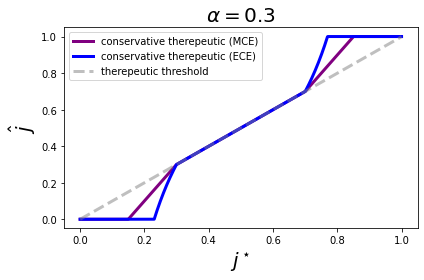

In [159]:
# comparing the thresholds
f1 = plot_optimal_threshold(m=1000, alpha=0.3, methods_to_plot=['mce', 'ece'], download=False)

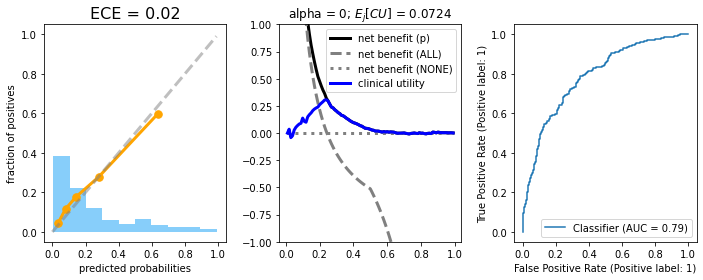

In [152]:
# the naive Logistic regression model is calibrated and not clinically harmful.
f2 = plot_baseline_model(m=100, n_bins=5)

<Figure size 432x288 with 0 Axes>

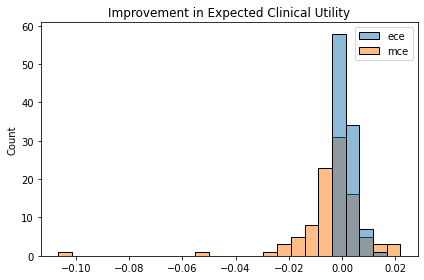

In [153]:
# comparing the therpetic thresholds on real data.
f3 = compare_ece_mce_on_data(T=100, m=100, n_bins=10)

<Figure size 432x288 with 0 Axes>

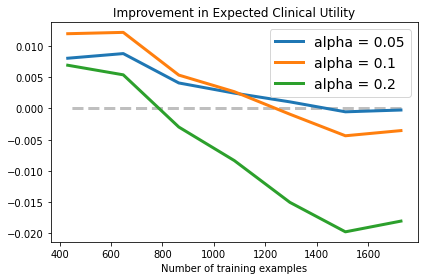

In [154]:
# small data experiment
f4 = plot_small_data_experiment(T=10, alphas=[0.05, 0.1, 0.2])

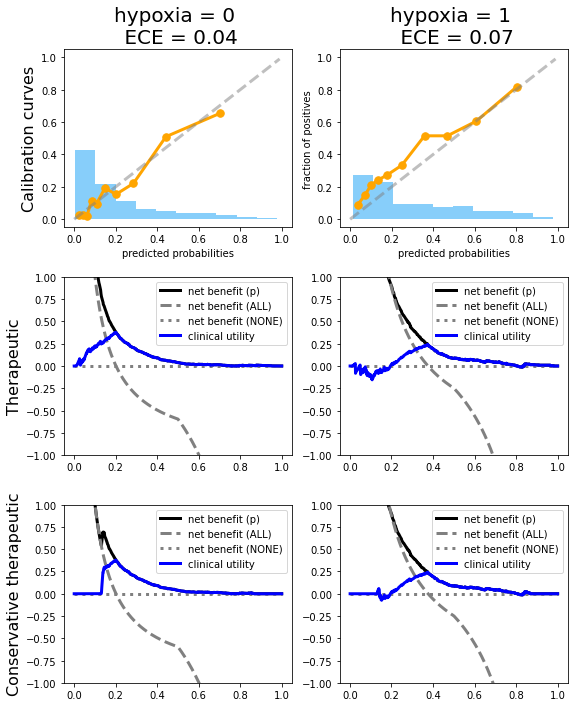

In [174]:
# comparison on variable omission
f5 = plot_omission_experiment(m=1000, n_bins=10, alpha=0.15)

# Download figures

In [169]:
for filename in [f1, f2, f3, f4, f5]:
  files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>